In [1]:
from datetime import date as Date, timedelta
from pathlib import Path
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import requests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
url = 'https://coronavirus.data.gov.uk/downloads/{data_type}/coronavirus-cases_latest.{data_type}'
base = '~/Downloads'
area = 'Area name'
date = 'Specimen date'
cases = 'Daily lab-confirmed cases'

force_download = False

lockdown = Date(2020, 3, 23)
testing = Date(2020, 4, 30)
relax_1 = Date(2020, 5, 11)

for_date = Date.today()-timedelta(days=1)

In [365]:
for suffix in 'csv', 'json':
    path = Path(base).expanduser() / f'coronavirus-cases_{Date.today()}.{suffix}'
    if force_download or not path.exists():
        response = requests.get(url.format(data_type=suffix))
        assert response.status_code==200
        with path.open('wb') as target:
            target.write(response.content)

In [3]:
brighton = 'E06000043'
west_sussex = 'E10000032'
east_sussex = 'E10000011'
areas = [brighton, west_sussex, east_sussex]

hammersmith = 'E09000013'
kensington = 'E09000020'
ealing = 'E09000009'
hounslow = 'E09000018'
richmond = 'E09000027'
wandsworth = 'E09000032'
brent = 'E09000005'

wirral = 'E08000015'
cheshire = 'E06000050'
liverpool = 'E08000012'
sefton = 'E08000014'
knowsley = 'E08000011'
st_helens = 'E08000013'

bristol = 'E06000023'
south_gloucestershire = 'E06000025'
bath = 'E06000022'
north_somerset = 'E06000024'
areas = [bristol, south_gloucestershire, bath, north_somerset]

hampshire = 'E10000014'
areas = [hampshire]

bedford = 'E06000055'
central_bedfordshire = 'E06000056'
areas = [bedford, central_bedfordshire]

northampton = 'E10000021'
milton_keynes =  'E06000042'
bedford = 'E06000055'
areas = [northampton, milton_keynes, bedford]

wokingham = 'E06000041'
reading = 'E06000038'
west_berks = 'E06000037'
bracknell = 'E06000036'
oxfordshire = 'E10000025'

In [4]:
def data_for_date(dt, areas):
    df = pd.read_csv(Path(base).expanduser() / f'coronavirus-cases_{dt}.csv')
    by_area = df[df['Area type'].str.startswith('Upper') & df['Area code'].isin(areas)]
    data = by_area[[date, area, cases]].pivot_table(values=cases, index=[date], columns=area).fillna(0)
    labels = pd.date_range(start=data.index.min(), end=data.index.max())
    return data.reindex([str(date.date()) for date in labels], fill_value=0)

In [5]:
def plot_stacked_bars(ax, data, uncertain_days):
    data.plot(
        ax=ax, kind='bar', stacked=True, width=1, rot=-90, colormap='viridis',
        title=cases, legend=False
    )

    mean = data.sum(axis=1).rolling(7).mean()
    mean[-uncertain_days:] = np.NaN
    mean.plot(ax=ax, color='k', label='7 day average', rot=-90)

    labels = ax.xaxis.get_ticklabels()
    for i, label in enumerate(reversed(labels)):
        if i%4:
            label.set_text('')
    ax.axes.set_axisbelow(True)
    ax.yaxis.grid(True)
    ax.xaxis.set_ticklabels(labels)

    ax.axvline(x=data.index.get_loc(str(lockdown)), color='r', linestyle='-', label='Lockdown')
    ax.axvline(x=data.index.get_loc(str(lockdown+timedelta(days=21))), color='r', linestyle='--', label='Lockdown + 3 weeks')
    ax.axvline(x=data.index.get_loc(str(testing)), color='b', linestyle=':', label='Testing ramped up')
    ax.axvline(x=data.index.get_loc(str(relax_1)), color='orange', linestyle='-', label='Relaxed Lockdown')

    latest_average = mean.iloc[-uncertain_days-1]
    ax.axhline(y=latest_average, color='grey', linestyle=':', label=f'Latest average: {latest_average:.1f}')

    ax.legend()  

    
def plot_diff(ax, for_date, data,previous_date, previous_data, areas):
    diff = data.sub(previous_data, fill_value=0)
    diff.plot(
        ax=ax, kind='bar', stacked=True, width=1, rot=-90, colormap='viridis',
        title=f'Change between reports on {previous_date} and {for_date}', legend=False
    )

    labels = ax.xaxis.get_ticklabels()
    for i, label in enumerate(reversed(labels)):
        if i%4:
            label.set_text('')
    ax.axes.set_axisbelow(True)
    ax.yaxis.grid(True)
    loc = plticker.MultipleLocator(base=1.0)
    ax.yaxis.set_major_locator(loc)
    ax.xaxis.set_ticklabels(labels)
    ax.axhline(y=0, color='k')

def plot(for_date, areas, uncertain_days):
    previous_date = for_date-timedelta(days=1)
    
    data = data_for_date(for_date, areas)
    previous_data = data_for_date(previous_date, areas)
    
    labels = [str(date.date()) for date in 
              pd.date_range(start=min(previous_data.index.min(), data.index.min()),
                            end=max(previous_data.index.max(), data.index.max()))]
    data = data.reindex(labels, fill_value=0)
    previous_data = previous_data.reindex(labels, fill_value=0)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), gridspec_kw={'height_ratios': [12, 2]})
    fig.set_facecolor('white')
    fig.subplots_adjust(hspace=0.5)
    
    

    
    plot_stacked_bars(axes[0], data, uncertain_days)
    plot_diff(axes[1], for_date, data, previous_date, previous_data, areas)
    plt.show()

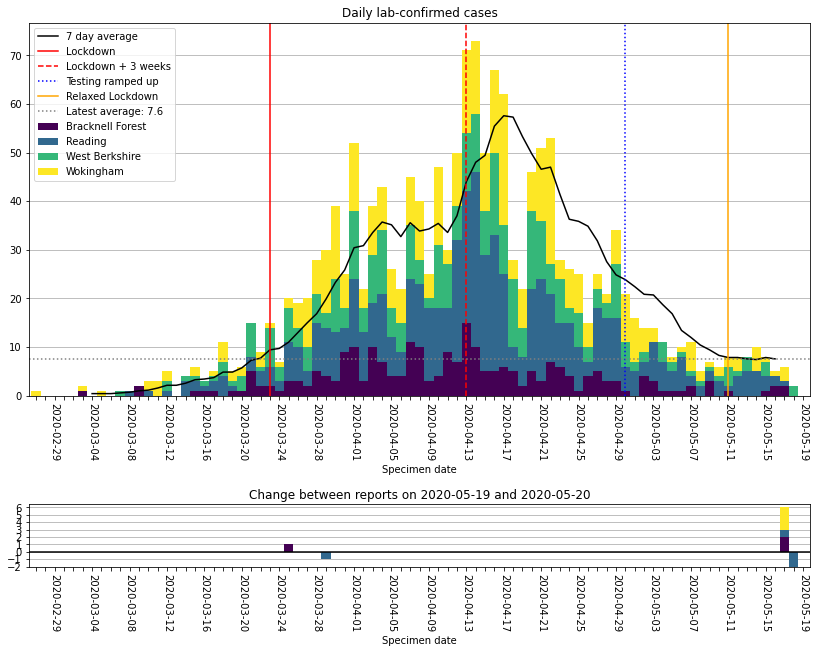

In [6]:
plot(for_date, areas = [wokingham, reading, west_berks, bracknell], uncertain_days=3)

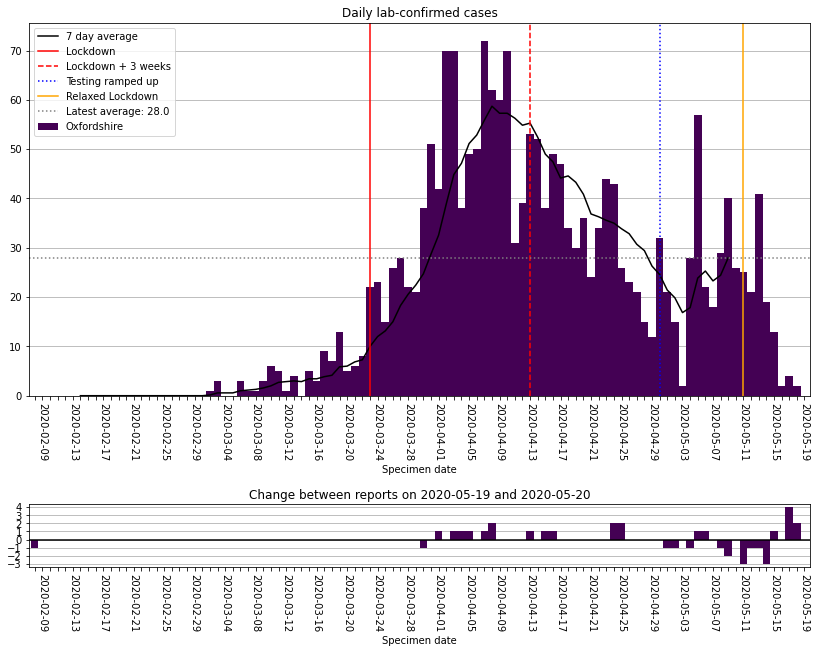

In [7]:
plot(for_date, areas = [oxfordshire], uncertain_days=10)

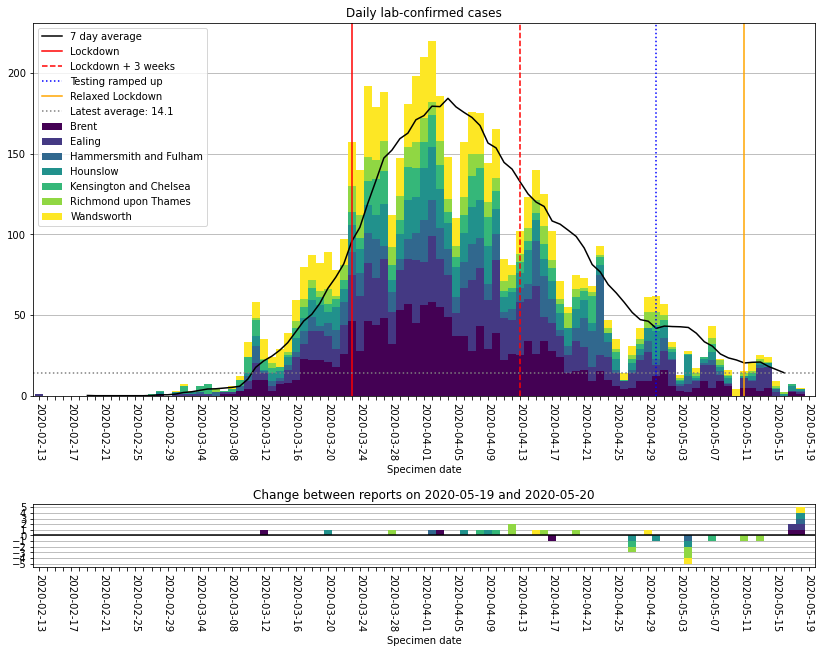

In [8]:
plot(for_date, areas = [hammersmith, kensington, ealing, hounslow, richmond, wandsworth, brent], uncertain_days=3)

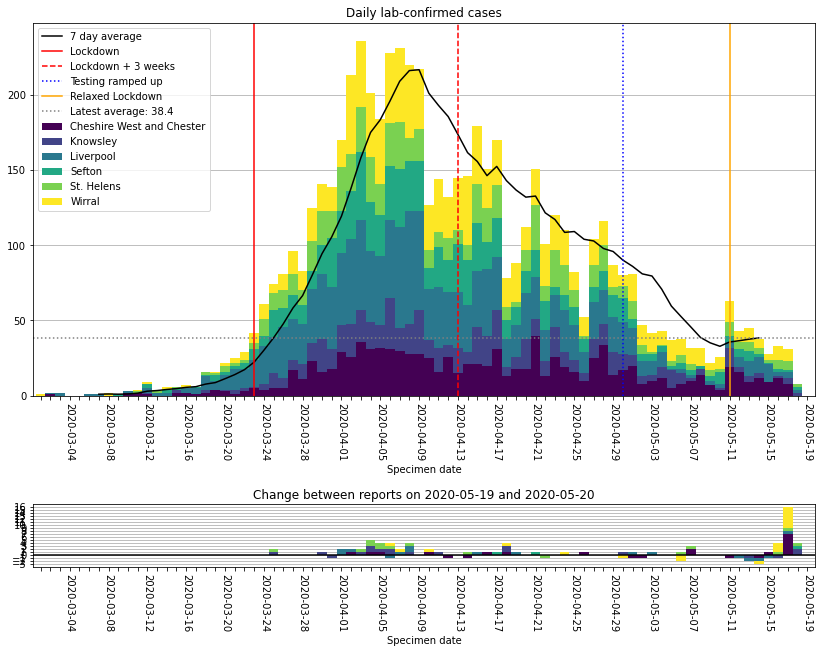

In [9]:
plot(for_date, areas = [wirral, cheshire, liverpool, sefton, knowsley, st_helens], uncertain_days=5)